# B-Trees

## Implementation

In [27]:
class BTreeNode:
    def __init__(self, leaf=False):
        """
        Initialize a B-tree node.

        Args:
            leaf (bool): Indicates whether the node is a leaf node.
        """
        self.leaf = leaf
        self.keys = []      # List to store keys
        self.children = []  # List to store child nodes


class BTree:
    def __init__(self, t):
        """
        Initialize a B-tree with a specified minimum degree.

        Args:
            t (int): Minimum degree of the B-tree.
        """
        self.root = BTreeNode(leaf=True)  # Initialize root node as a leaf node
        self.t = t  # Minimum degree of the B-tree

    def search(self, key):
        """
        Perform a search operation to find a key in the B-tree.

        Args:
            key: Key to search for in the B-tree.

        Returns:
            bool: True if the key is found, False otherwise.
        """
        return self._search(self.root, key)

    def _search(self, node, key):
        """
        Helper function to recursively search for a key in a node or its children.

        Args:
            node (BTreeNode): Current node being searched.
            key: Key to search for.

        Returns:
            bool: True if the key is found, False otherwise.
        """
        if not node:
            return False

        i = 0
        while i < len(node.keys) and key > node.keys[i]:
            i += 1
        
        if i < len(node.keys) and key == node.keys[i]:
            return True
        elif node.leaf:
            return False
        else:
            if i < len(node.children):
                return self._search(node.children[i], key)
            else:
                return False  # Return False if child index is out of range

    def insert(self, key):
        """
        Insert a key into the B-tree.

        Args:
            key: Key to insert into the B-tree.
        """
        root = self.root
        if len(root.keys) == (2 * self.t) - 1:
            # Split the root if it is full
            new_root = BTreeNode()
            new_root.children.append(root)
            self._split_child(new_root, 0)
            self.root = new_root
            self._insert_non_full(new_root, key)
        else:
            self._insert_non_full(root, key)

    def _insert_non_full(self, node, key):
        """
        Helper function to recursively insert a key into a non-full node.

        Args:
            node (BTreeNode): Current node to insert the key into.
            key: Key to insert.
        """
        i = len(node.keys) - 1
        if node.leaf:
            # Insert key into a leaf node
            node.keys.append(0)  # Placeholder for the new key
            while i >= 0 and key < node.keys[i]:
                node.keys[i + 1] = node.keys[i]  # Shift keys to make space for new key
                i -= 1
            node.keys[i + 1] = key  # Place the new key in the correct position
        else:
            # Insert key into an internal node
            while i >= 0 and key < node.keys[i]:
                i -= 1
            i += 1
            if i < len(node.children):
                # Check if child node is full before insertion
                if len(node.children[i].keys) == (2 * self.t) - 1:
                    self._split_child(node, i)
                    if key > node.keys[i]:
                        i += 1
            if i >= len(node.children):
                i = len(node.children) - 1
            self._insert_non_full(node.children[i], key)

    def _split_child(self, parent, i):
        """
        Split a full child node of the parent node.

        Args:
            parent (BTreeNode): Parent node containing the full child.
            i (int): Index of the full child to be split.
        """
        t = self.t
        child = parent.children[i]
        new_child = BTreeNode(leaf=child.leaf)
        parent.keys.insert(i, child.keys[t - 1])  # Promote median key to parent
        parent.children.insert(i + 1, new_child)
        new_child.keys = child.keys[t:(2 * t) - 1]  # Move keys to the new child
        child.keys = child.keys[0:t - 1]  # Update keys in the original child
        if not child.leaf:
            new_child.children = child.children[t:2 * t]
            child.children = child.children[0:t - 1]

    def _get_predecessor(self, node):
        """
        Helper method to find the predecessor key in a subtree.
        """
        if not node:
            return None

        # Traverse to the rightmost node in the subtree
        while node and not node.leaf:
            node = node.children[-1]

        # Return the rightmost key
        return node.keys[-1] if node else None

    def _get_successor(self, node):
        """
        Helper method to find the successor key in a subtree.
        """
        if not node:
            return None

        # Traverse to the leftmost node in the subtree
        while node and not node.leaf:
            node = node.children[0]

        # Return the leftmost key
        return node.keys[0] if node else None


    def delete(self, key):
        """
        Delete a key from the B-tree.

        Args:
            key: Key to delete from the B-tree.
        """
        if not self.root:
            print("The tree is empty.")
            return
        self._delete(self.root, key)
        if len(self.root.keys) == 0 and len(self.root.children) == 1:
            self.root = self.root.children[0]

    def _delete(self, node, key):
        """
        Helper function to recursively delete a key from a node.

        Args:
            node (BTreeNode): Current node to start deletion from.
            key: Key to delete.
        """
        if not node:
            return

        t = self.t
        i = 0
        while i < len(node.keys) and key > node.keys[i]:
            i += 1

        if i < len(node.keys) and node.keys[i] == key:
            if node.leaf:
                # Case 1: Key is in a leaf node
                del node.keys[i]
            else:
                # Case 2: Key is in an internal node
                if len(node.children) > i:
                    child = node.children[i]
                    if len(child.keys) >= t:
                        # Case 2a: Child has at least t keys
                        predecessor = self._get_predecessor(child)
                        node.keys[i] = predecessor
                        self._delete(child, predecessor)
                    elif i + 1 < len(node.children):
                        # Case 2b: Right sibling exists
                        sibling = node.children[i + 1]
                        if len(sibling.keys) >= t:
                            successor = self._get_successor(sibling)
                            node.keys[i] = successor
                            self._delete(sibling, successor)
                        else:
                            # Case 2c: Merge with sibling
                            self._merge(node, i)
                            self._delete(child, key)
        else:
            # Case 3: Key is not present in current node
            child_index = i
            if len(node.children) > child_index:
                child = node.children[child_index]
                if len(child.keys) == t - 1:
                    # Case 3a: Borrow from left or right sibling
                    if child_index > 0 and len(node.children[child_index - 1].keys) >= t:
                        self._borrow_from_left(node, child_index)
                    elif child_index < len(node.children) - 1 and len(node.children[child_index + 1].keys) >= t:
                        self._borrow_from_right(node, child_index)
                    else:
                        # Case 3b: Merge with left or right sibling
                        if child_index < len(node.children) - 1:
                            self._merge(node, child_index)
                        else:
                            self._merge(node, child_index - 1)

            # Recursively delete in the appropriate child node
            if len(node.children) > child_index:
                self._delete(node.children[child_index], key)

    def _merge(self, node, child_index):
        """
        Merge a child node with its sibling.

        Args:
            node (BTreeNode): Parent node containing the child and its sibling.
            child_index (int): Index of the child node to be merged.
        """
        t = self.t
        child = node.children[child_index]
        sibling = node.children[child_index + 1]

        # Merge child with sibling
        child.keys.append(node.keys[child_index])
        child.keys.extend(sibling.keys)
        child.children.extend(sibling.children)

        # Remove sibling node
        del node.keys[child_index]
        del node.children[child_index + 1]

    def _borrow_from_left(self, node, child_index):
        """
        Borrow a key from the left sibling of a child node.

        Args:
            node (BTreeNode): Parent node containing the child and its left sibling.
            child_index (int): Index of the child node to borrow from.
        """
        child = node.children[child_index]
        sibling = node.children[child_index - 1]

        # Shift key from parent to child
        child.keys.insert(0, node.keys[child_index - 1])
        if not child.leaf:
            child.children.insert(0, sibling.children.pop())

        # Update parent key
        node.keys[child_index - 1] = sibling.keys.pop()

    def _borrow_from_right(self, node, child_index):
        """
        Borrow a key from the right sibling of a child node.

        Args:
            node (BTreeNode): Parent node containing the child and its right sibling.
            child_index (int): Index of the child node to borrow from.
        """
        child = node.children[child_index]
        sibling = node.children[child_index + 1]

        # Shift key from parent to child
        child.keys.append(node.keys[child_index])
        if not child.leaf:
            child.children.append(sibling.children.pop(0))

        # Update parent key
        node.keys[child_index] = sibling.keys.pop(0)

## Benchmark Function

In [28]:
import random
import time

def benchmark_operations_with_sizes(btree, operation, max_size=10000, step=1000):
    """
    Benchmark B-tree operations (insertion, search, deletion) with varying dataset sizes.

    Args:
        btree (BTree): B-tree object to benchmark.
        operation (str): Type of operation ('insert', 'search', 'delete').
        max_size (int): Maximum dataset size to benchmark.
        step (int): Step size for increasing the dataset.

    Returns:
        list: List of tuple pairs (dataset size, time taken).
    """
    results = []
    
    for size in range(step, max_size + 1, step):
        keys_to_process = random.sample(range(max_size), size)
        
        start_time = time.time()
        for key in keys_to_process:
            if operation == 'insert':
                btree.insert(key)
            elif operation == 'search':
                btree.search(key)
            elif operation == 'delete':
                btree.delete(key)
        end_time = time.time()
        
        operation_time = end_time - start_time
        results.append((size, operation_time))
    
    return results


## Plotting Function

In [29]:
import matplotlib.pyplot as plt

def plot_benchmark_results(results, operation, max_size=10000, step=1000):
    """
    Plot the benchmark results for a specific operation with varying dataset sizes.

    Args:
        results (list): List of tuple pairs (dataset size, time taken) for the operation.
        operation (str): Type of operation ('insert', 'search', 'delete').
        max_size (int): Maximum dataset size to benchmark.
        step (int): Step size for increasing the dataset.
    """
    sizes, times = zip(*results)
    
    plt.figure(figsize=(10, 6))
    plt.plot(sizes, times, marker='o', linestyle='-', label=f'{operation.capitalize()} Operation')
    
    plt.title(f'Performance of {operation.capitalize()} Operation with Varying Dataset Sizes')
    plt.xlabel('Dataset Size')
    plt.ylabel('Time (seconds)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [35]:
# Initialize a B-tree with minimum degree 2
btree = BTree(t=2)

# Set the maximum dataset size and step size for benchmarking
max_size = 10000
step = 1000

### Benchmark insertion operation

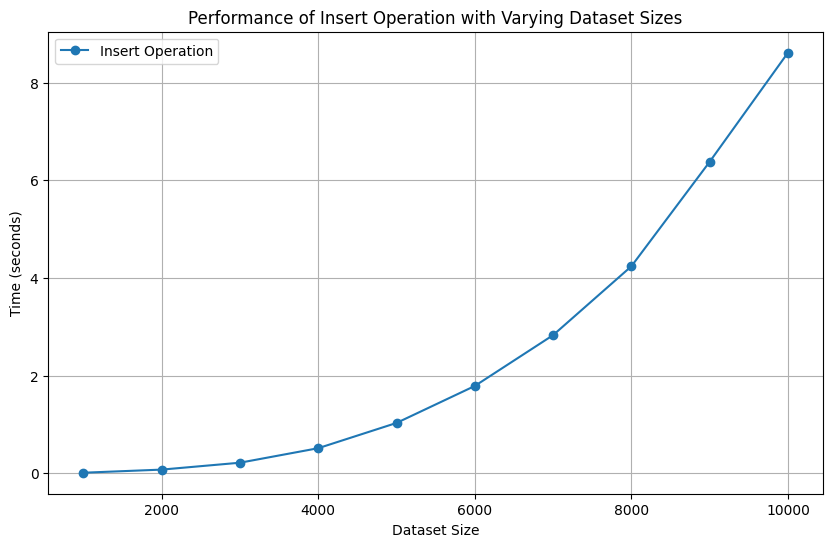

In [36]:
insertion_results = benchmark_operations_with_sizes(btree, 'insert', max_size, step)
plot_benchmark_results(insertion_results, 'insert', max_size, step)

### Benchmark search operation

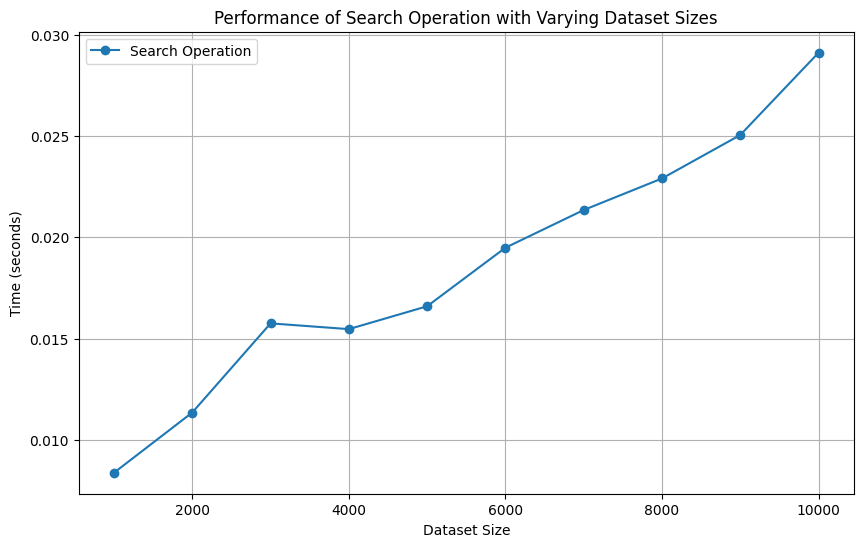

In [38]:
search_results = benchmark_operations_with_sizes(btree, 'search', max_size, step)
plot_benchmark_results(search_results, 'search', max_size, step)

### Benchmark deletion operation

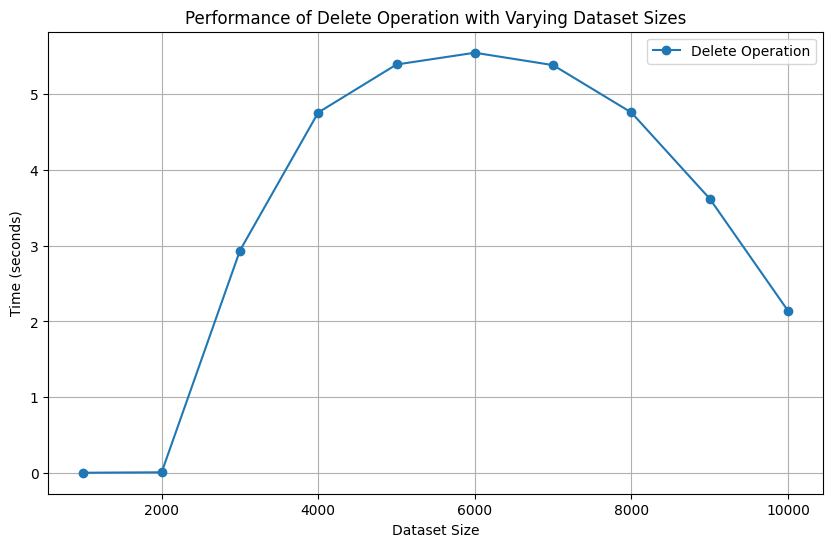

In [39]:
deletion_results = benchmark_operations_with_sizes(btree, 'delete', max_size, step)
plot_benchmark_results(deletion_results, 'delete', max_size, step)